# Evolução Diferencial (Peaks)

__Alunos:__
- Eduardo Villani - 2015104008
- Hugo Zanini - 2015016044
---

Problema: Dada uma função f qualquer em um espaço N, determinar o valor
mínimo dessa função em um espaço da dimensão. A diferença mais importante entre esse método e os já estudados
é a forma como fazemos a geração de uma perturbação. Escolhemos 3 pontos (de forma aleatório ou usando outro
método) e com isso, calculamos a seguinte "nova geração":

$v_{t,i} = x_{t,r_1} + F*(x_{t,r_2} - x_{t,r_3})$

Onde F é um fator de escala.

## Solução
---
### Algortimo genético
1. Inicie uma população com N indivíduos,
cada um de tamanho igual a dimensão do problema;
3. Enquanto não tivermos o máximo de iterações ou o melhor fit não se altere durante *G* gerações faça:

    3.1 Selecione 3 indivíduos (aleatoriamente ou por outro método);

    3.2 Escolha uma dimensão aleatorio;

    3.3 Escolha um C aleatorio

    3.4 Para cada filho, gere uma coordenada

    3.4.1 Se p <= C *OU* estamos na dimensão aleatório, coordenada é da função;

    3.4.2 Se não, coordenada do pai;

    3.5 Escolha os indivíduos da próxima geração;

    3.5.1 Se fit filho > fit pai, então mantemos o pai;

    3.5. Se não, filho;

    3.6 Volte para 3
---

### Código

In [1]:
import warnings
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import MatplotlibDeprecationWarning
from numpy.random.mtrand import uniform, choice, randint


class DifferentialEvolution:

    def __init__(self, n_pop, axis_range, max_gen=10000, max_gen_to_converge=50, method='random', C=None, F=None):
        self._n_pop = n_pop
        self._axis_range = axis_range
        self._method = method
        self._max_gen = max_gen
        self._max_gen_to_converge = max_gen_to_converge
        self._c = C
        self._f = F
        self._data_per_gen = None

    def arg_min(self, func, log=False):
        func = func
        n_pop = self._n_pop
        axis_ranges = self._axis_range
        MAX_GEN = self._max_gen
        F = self._f
        C = self._c

        pop = DifferentialEvolution.init_population(axis_ranges, n_pop, 2)
        current_min = np.inf
        max_gen_to_converge = self._max_gen_to_converge
        hit = 0

        data_arg_min = []
        for i in range(MAX_GEN):
            children = DifferentialEvolution.gen_children(pop, func=func, C=C, F=F, method=self._method)
            pop = DifferentialEvolution.select_new_generation(pop, children, func)
            fit = DifferentialEvolution.pop_fitness(pop, func)
            if log:
                print(f"Generation {i} - MIN {min(fit)} - MEAN {np.mean(fit)} - MAX {max(fit)}")
            data_arg_min.append([i, min(fit), np.mean(fit), max(fit)])

            if min(fit) < current_min:
                current_min = min(fit)
                hit = 0
            if min(fit) == current_min:
                hit = hit + 1
            if hit > max_gen_to_converge:
                self._data_per_gen = np.array(data_arg_min)
                return np.array(data_arg_min)

    def plot(self):
        warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
        plt.plot(self._data_per_gen.T[0], self._data_per_gen.T[2], '-', label='Fitness médio')
        plt.xlabel('Geração')
        plt.ylabel('Fitness')
        plt.plot(self._data_per_gen.T[0], self._data_per_gen.T[1], '-', label='Fitness minimo')
        plt.plot(self._data_per_gen.T[0], self._data_per_gen.T[3], '-', label='Fitness máximo')
        plt.legend(loc="upper left")
        plt.title('Evolução do fitness máximo, médio e minimo')
        plt.subplot(111).legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

    @staticmethod
    def init_population(axis_range, n_pop, dimensions):
        return uniform(*axis_range, size=(n_pop, dimensions))

    @staticmethod
    def pop_fitness(pop, func):
        return np.array(list(map(func, pop)))

    @staticmethod
    def pick_rs(pop, func, method='random'):
        if method == 'random':
            index = choice(len(pop), 3, replace=False)
            return deepcopy(pop[index])
        elif method == 'mean':
            rs1 = np.mean(pop, 0)
            index = choice(len(pop), 2, replace=False)
            return np.insert(pop[index], 0, rs1, 0)
        elif method == 'min':
            aux_pop = deepcopy(pop)
            fit = DifferentialEvolution.pop_fitness(aux_pop, func)
            index_min = np.argmin(fit)
            rs1 = aux_pop[index_min]
            aux_pop = np.delete(aux_pop, index_min, 0)
            index = choice(len(aux_pop), 2, replace=False)
            return np.insert(aux_pop[index], 0, rs1, 0)

    @staticmethod
    def select_new_generation(pop, children, func):
        def pick_child_or_father(funct, child, father):
            if funct(child) <= funct(father):
                return child
            else:
                return father

        new_gen = [pick_child_or_father(func, child, father) for father, child in zip(pop, children)]
        return np.array(new_gen)

    @staticmethod
    def gen_children(pop, method, func, C=None, F=None):
        def gen_selector():
            if C is None:
                return uniform(0.6, 0.9)
            else:
                return C

        def gen_scale():
            if F is None:
                return uniform(0.7, 0.9)
            else:
                return F

        def pick_coordinates(being, rs, index, delta):
            if uniform() <= gen_selector() or delta == index:
                return rs[0][index] + gen_scale() * (rs[1][index] - rs[2][index])
            else:
                return being[index]

        def gen_child(being):
            rs = DifferentialEvolution.pick_rs(pop, func, method)
            delta = randint(0, rs.shape[1])
            return np.array(
                [
                    pick_coordinates(being, rs, index, delta) for index, value in enumerate(being)
                ]
            )

        return np.array([gen_child(being) for being in pop])

## Testes


##### Com a função peaks, o primeiro teste consiste em manter variar a população inicial e vermos como se comportam a convergência

In [3]:
def rastrigin(x):
    Q = np.identity(len(x))
    X = Q @ x
    n = len(x)
    F = 0

    for i in range(n):
        F = F + X[i] ** 2 - 10 * np.cos(2 * np.pi * X[i])
    return F

### N = 10 e MAX = 50

[169. -20. -20. -20.]


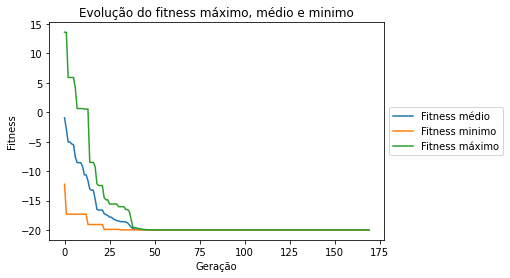

In [8]:

n_pop = 10
axis_ranges = (-2, 2)
func = rastrigin

de = DifferentialEvolution(
    n_pop,
    axis_ranges,
    max_gen_to_converge=50
)
print(de.arg_min(func, False)[-1])
de.plot()

### N = 50 e MAX = 50

[164. -20. -20. -20.]


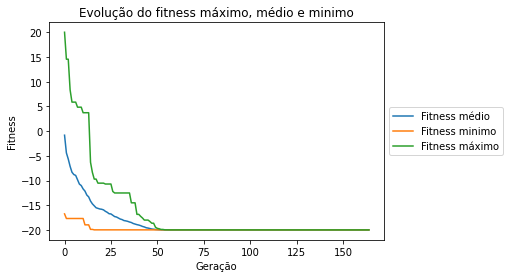

In [9]:
n_pop = 50
axis_ranges = (-2, 2)
func = rastrigin

de = DifferentialEvolution(
    n_pop,
    axis_ranges,
    max_gen_to_converge=50
)
print(de.arg_min(func, False)[-1])
de.plot()

### N = 100 e MAX = 50

[163. -20. -20. -20.]


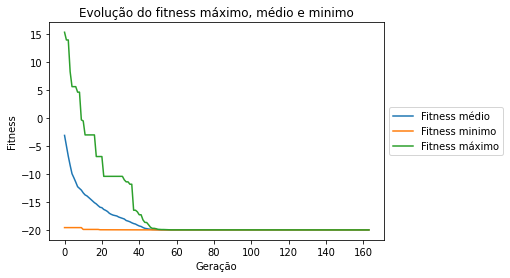

In [13]:
n_pop = 100
axis_ranges = (-2, 2)
func = rastrigin

de = DifferentialEvolution(
    n_pop,
    axis_ranges,
    max_gen_to_converge=50
)
print(de.arg_min(func, False)[-1])
de.plot()


##### O próximo teste consiste em variar o metodo de seleção para vereficarmos se temos alguma melhora.
Os metodos são: aleatorio, minimo (best fit) e média. A população será mantida em

### N = 100 e method = random

[170. -20. -20. -20.]


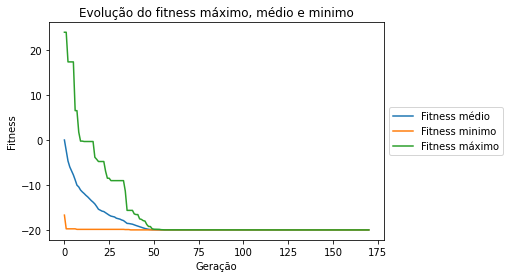

In [12]:
n_pop = 100
axis_ranges = (-2, 2)
func = rastrigin

de = DifferentialEvolution(
    n_pop,
    axis_ranges,
    max_gen_to_converge=50,
    method='random'
)
print(de.arg_min(func, False)[-1])
de.plot()

In [ ]:
### N = 100 e method = min

[120. -20. -20. -20.]


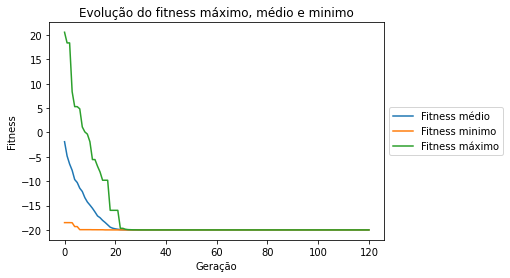

In [14]:
n_pop = 100
axis_ranges = (-2, 2)
func = rastrigin

de = DifferentialEvolution(
    n_pop,
    axis_ranges,
    max_gen_to_converge=50,
    method='min'
)
print(de.arg_min(func, False)[-1])
de.plot()


In [ ]:
### N = 100 e method = mean

[ 58.         -19.99136472 -17.31205515 -12.24422168]


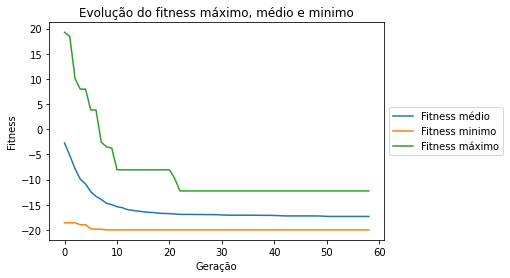

In [15]:
n_pop = 100
axis_ranges = (-2, 2)
func = rastrigin

de = DifferentialEvolution(
    n_pop,
    axis_ranges,
    max_gen_to_converge=50,
    method='mean'
)
print(de.arg_min(func, False)[-1])
de.plot()


## Conclusões

Notamos a diferença entre os metodos utilizados, com a escolha do melhor fit sendo melhor que os demais, valor médio
com segundo melhor e escolha aleatorio como o terceiro. Todos acabam convergindo para o valor desejado. Também
não chegamos a notar grandes diferenças no valor de convergencia para os valores iniciais de população para
a função rastrigin, mas isso considerando a determinação de max_gen. É notavel que quanto maior a pop. inicial,
mais cedo chegamos no valor desejado.  